### Initialization

In [4]:
#Initial setup
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model

import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

#Read Titanic data
titanic_df = pd.read_csv("train.csv")

### Data cleaning

In [7]:
#Check the unique values for variables that should have a small number of possible values
print("Unique values for 'Sex':", pd.unique(titanic_df["Sex"]))
print("Unique values for 'Pclass':", sorted(pd.unique(titanic_df["Pclass"])))
print("Unique values for 'SibSp':", sorted(pd.unique(titanic_df["SibSp"])))
print("Unique values for 'Parch':", sorted(pd.unique(titanic_df["Parch"])))
print("Unique values for 'Embarked':", pd.unique(titanic_df["Embarked"]))

#Check min, max, 10th, 25th, 50th, 75th, and 90th quartiles for 'Age' field
print("Age percentiles\n", "\n".join(["\t%dth pctl: %.5f" % (n, titanic_df["Age"].quantile(n/100)) for n in [0, 10, 25, 50, 75, 90, 100]]))
print("\tnull values:", titanic_df["Age"].isna().sum())
#Impute missing ages with the mean age
titanic_df["Age"].fillna(titanic_df["Age"].mean(), inplace=True)

#Check min, max, 10th, 25th, 50th, 75th, and 90th quartiles for 'Fare' field
print("Fare percentiles\n", "\n".join(["\t%dth pctl: %.5f" % (n, titanic_df["Fare"].quantile(n/100)) for n in [0, 10, 25, 50, 75, 90, 100]]))
print("\tnull values:", titanic_df["Fare"].isna().sum())
#Impute missing fares with the mean fare
titanic_df["Fare"].fillna(titanic_df["Fare"].mean(), inplace=True)

Unique values for 'Sex': ['male' 'female']
Unique values for 'Pclass': [1, 2, 3]
Unique values for 'SibSp': [0, 1, 2, 3, 4, 5, 8]
Unique values for 'Parch': [0, 1, 2, 3, 4, 5, 6]
Unique values for 'Embarked': ['S' 'C' 'Q' nan]
Age percentiles
 	0th pctl: 0.42000
	10th pctl: 16.00000
	25th pctl: 22.00000
	50th pctl: 29.69912
	75th pctl: 35.00000
	90th pctl: 47.00000
	100th pctl: 80.00000
	null values: 0
Fare percentiles
 	0th pctl: 0.00000
	10th pctl: 7.55000
	25th pctl: 7.91040
	50th pctl: 14.45420
	75th pctl: 31.00000
	90th pctl: 77.95830
	100th pctl: 512.32920
	null values: 0


Data cleaning takeaways:
* There are no unusual values in the Sex, Pclass, SibSp, or Parch column. 
* The Embarked column has some missing values, but no other unusual values.
* There do not appear to be any unusual values in the Age column, although there are 177 missing values. The missing ages were imputed with the mean age.
* There do not appear to be any unusual values in the Fare column. A fare of 0.0 could be interpreted as a ticket provided for free. Although the maximum value is significantly higher than the 90th percentile value, there are a number other of high-cost tickets.

### Exploratory Data Analysis

In [39]:
#Take average of each field for each passenger class
#For non-numeric features, the percentage of each group with each possible value is used
pclass_df = titanic_df.copy()
pclass_df.drop(columns="PassengerId", inplace=True)
pclass_df["% Male"] = (pclass_df["Sex"] == "male")
pclass_df["% Female"] = 1 - pclass_df["% Male"]
pclass_df["% from C"] = (pclass_df["Embarked"] == "C")
pclass_df["% from Q"] = (pclass_df["Embarked"] == "Q")
pclass_df["% from S"] = (pclass_df["Embarked"] == "S")
pclass_average_df = pclass_df.groupby("Pclass").mean()
pclass_average_df[["Age", "SibSp", "Parch", "Fare", "% Male", "% Female", "% from C", "% from Q", "% from S"]]

,Age,SibSp,Parch,Fare,% Male,% Female,% from C,% from Q,% from S
Pclass,,,,,,,,,
1,37.048118,0.416667,0.356481,84.154687,0.564815,0.435185,0.393519,0.009259,0.587963
2,29.866958,0.402174,0.380435,20.662183,0.586957,0.413043,0.092391,0.016304,0.891304
3,26.403259,0.615071,0.393075,13.675550,0.706721,0.293279,0.134420,0.146640,0.718941


From an analysis based on passenger ticket class, it can be determined that:
* The higher the class, the older passengers are on average.
* On average, third-class passengers had more total siblings/spouses on board than first-class and second-class passengers. First-class passengers had slightly fewer parents/children on board than second-class and third-class passengers.
* First-class passengers paid significantly higher fares than second-class and third-class passengers.
* The majority of passengers in each group were male, but there was a higher percentage of males amongst third-class passengers.
* Most passengers departed from Southampton.
* Out of the three classes, first-class passengers were most likely to have departed from Cherbourg.
* Out of the three classes, third-class passengers were most likely to have departed from Queenstown.

In [40]:
#For discrete variables, determine the percentage of people from each group who survived.
print(titanic_df.groupby("Sex")["Survived"].mean())
print(titanic_df.groupby("Pclass")["Survived"].mean())
print(titanic_df.groupby("Embarked")["Survived"].mean())

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64
Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


* Female passengers were more likely to survive than male passengers.
* Passengers with first-class tickets were most likely to survive, followed by those with second-class tickets, followed by those with third-class tickets.
* Passengers who embarked at Cherbourg were most likely to survive, followed by those who embarked at Queenstown, followed by those who embarked at Southampton.
  * This may be due to the fact that first-class passengers were the most likely to have embarked at Cherbourg.

<AxesSubplot:>

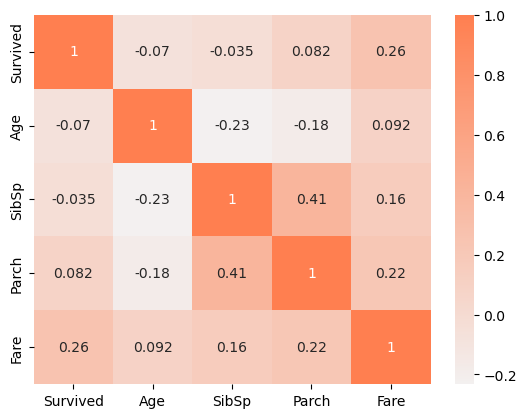

In [42]:
#Find correlations between each numeric variable
correlations = titanic_df[["Survived", 
                    "Age", 
                    "SibSp", 
                    "Parch", 
                    "Fare"
                ]].corr()
correlation_cmap = sns.light_palette(color="#FF7F50", as_cmap=True)
sns.heatmap(correlations, cmap=correlation_cmap, annot=True)

**Exploratory data analysis conclusions**

Socio-economic status and gender seem to be the most important factors in survival chance. Embark location can predict survival chance to an extent, but that likely reflects the socio-economic status of people who embarked at each location. 